# Tax Rate Analysis Report - v4

## Introduction

This report presents an analysis of the impact of tax rates and funding rate yields on the USDe supply within the Ethena protocol. The study employs a series of simulations and sensitivity analyses to understand how changes in these parameters affect key metrics such as USDe supply, sUSDe supply, and staked USDe.

## Methodology

### Data Collection

The analysis begins by collecting current data from various sources:

1. Collateral data from the Ethena API
2. Reserve fund data from the Ethena API
3. Smart contract data for USDe and sUSDe supplies using Web3 interactions

### Simulation Model

A simulation model was developed to iterate through potential scenarios. The core of this model consists of two main functions:

1. `iteration()`: Performs a single iteration of the tax rate analysis, calculating new values for USDe supply, sUSDe supply, and staked USDe based on given parameters.

2. `iteration_loop()`: Runs multiple iterations until convergence or a maximum number of iterations is reached, allowing the system to stabilize under new conditions.

The model takes into account several factors:

- Collateral positions
- USDe and sUSDe supplies
- Staked USDe amounts
- Funding rate yields
- Current and target tax rates
- LST (Liquid Staking Token) positions and yields

### Sensitivity Analysis

A comprehensive sensitivity analysis was conducted using the `sensitivity_analysis_ext()` function. This function explores the impact of varying two key parameters:

1. Funding Rate Yield: Ranging from 4% to 10%
2. Target Tax Rate: Ranging from 10% to 90%

The analysis calculates the changes in USDe supply, sUSDe supply, staked USDe, LST positions, and total positions for each combination of these parameters.

## Results

### Initial Simulations

Two initial simulations were run with different parameters:

1. Funding rate yield of 7%, target tax rate of 20%
2. Funding rate yield of 1%, target tax rate of 90%

These simulations provided insights into how extreme changes in tax rates and funding yields could affect the protocol's key metrics.

### Sensitivity Analysis Results

The sensitivity analysis produced a rich dataset showing how USDe supply changes across different combinations of funding rate yields and target tax rates. Key findings include:

1. USDe Supply Change Heatmap:
   - A visualization was created showing the change in USDe supply for different combinations of funding rate yields and target tax rates.
   - The heatmap reveals areas of growth and contraction in the USDe supply.
   - Contour lines on the heatmap indicate the starting USDe supply levels, providing context for the magnitude of changes.

2. USDe Supply Heatmap:
   - Another heatmap was generated to show the final USDe supply levels across different parameter combinations.
   - This visualization helps identify optimal combinations of funding rate yields and tax rates for maximizing USDe supply.

3. Impact of Tax Rate on USDe Supply:
   - A line plot was created to show how the target tax rate affects initial and final USDe supplies, given a specific funding rate yield of 7%.
   - This plot demonstrates the sensitivity of USDe supply to changes in the tax rate, holding the funding rate yield constant.

## Conclusions

The analysis reveals that the target tax rate have significant impacts on the future USDe supply and other key metrics of the Ethena protocol. The sensitivity analysis provides a comprehensive view of how these parameters interact to influence the protocol's behavior.

Key observations include:

1. Higher funding rate yields generally lead to increased USDe supply, but the relationship is not linear and depends on the tax rate.
2. Lower tax rates tend to result in higher USDe supplies, but again, this relationship is complex and interacts with the funding rate yield.
3. There appear to be optimal combinations of funding rate yields and tax rates that maximize USDe supply, which could be valuable for protocol management.

These findings can inform decision-making regarding tax rate adjustments and funding rate management within the Ethena protocol, helping to optimize its performance and stability.

## Limitations and Future Work

While this analysis provides valuable insights, it's important to note that it relies on building the collateral portfolio in the same proportion as the current collateral portfolio. A model that can allocate the collateral in the best possible way is something being considered. Also there are some consequences of low tax rates as it directly impacts the inflow towards the reserve fund.

In [36]:
from requests import get, post
from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict


- Reads two CSV files: "BTC_impact.csv" and "ETH_impact.csv"
- Concatenates these dataframes into a single `drawdown_df`
- Converts the combined dataframe to a dictionary `drawdown_dict`



In [37]:
# Read the CSV files
BTC_impact = pd.read_csv("BTC_impact.csv")
ETH_impact = pd.read_csv("ETH_impact.csv")

# Concatenate the dataframes
drawdown_df = pd.concat([BTC_impact, ETH_impact], ignore_index=True)

# Convert the dataframe to a dictionary
drawdown_dict = drawdown_df.to_dict(orient='list')


- Fetches current collateral data from the Ethena API
- Calculates the total position value
- Computes the proportion of each collateral entry relative

In [38]:
# Fetch current collateral data from the API
url_collateral = "https://app.ethena.fi/api/positions/current/collateral"
response_collateral = get(url_collateral)
data_collateral = response_collateral.json()

current_collateral_data = data_collateral.get('collateral', [])

total_position = sum(entry['usdAmount'] for entry in current_collateral_data)

collateral_prop = current_collateral_data.copy()

for entry in collateral_prop:
    entry['proportion'] = entry['usdAmount'] / total_position



- Defines asset groups (LST and short position)
- Implements `compute_lst_position()` function to calculate LST positions
- Implements `calculate_returns()` function to compute returns based on amount, duration, and rate

In [39]:
LST_group = ['stETH', 'mETH', 'LsETH', 'WBETH']
short_position_group = ['ETH', 'LST', 'BTC']

def compute_lst_position(collateral_data=collateral_prop,group_assets=LST_group):
    """Compute the LST position by summing the USD amounts for LST assets across all exchanges."""
    
    grouped_data = defaultdict(lambda: {'usdAmount': 0, 'timestamp': 0})

    for entry in collateral_data:
        if entry['asset'] in group_assets:
            exchange = entry['exchange']
            grouped_data[exchange]['usdAmount'] += entry['usdAmount']
            grouped_data[exchange]['timestamp'] = max(grouped_data[exchange]['timestamp'], entry['timestamp'])
    
    new_entries = []
    for exchange, data in grouped_data.items():
        new_entries.extend([
            {'asset': 'ETH', 'exchange': exchange, 'timestamp': data['timestamp'], 'usdAmount': data['usdAmount']},
            {'asset': 'LST', 'exchange': exchange, 'timestamp': data['timestamp'], 'usdAmount': data['usdAmount']}
        ])
        
    # Sum all the usdAmount for LST
    lst_sum = sum(entry['usdAmount'] for entry in new_entries if entry['asset'] == 'LST')
    
    return lst_sum


def calculate_returns(total_usd_amount, duration, rate):
    """Calculate LST return based on total amount, duration, and daily rate."""
    return duration * rate * total_usd_amount / 365

- Retrieves reserve fund data from the Ethena API and extracts the actual reserve size.

In [40]:
url_funds = "https://app.ethena.fi/api/solvency/reserve-fund"
data_funds = get(url_funds).json()
yields = data_funds.get('queryIndex', [{}])[0].get('yields', [])
actual_reserve_size = max(yields, key=lambda x: x['timestamp'])['value']

- Loads environment variables
- Establishes a Web3 connection using Alchemy
- Defines a `query_smart_contract()` function for interacting with smart contracts


In [41]:
# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='../.env')

# Verify that the environment variable is loaded correctly
alchemy_key = os.getenv('ALCHEMY_KEY')

# Create the Web3 provider using the Alchemy URL
# w3 = Web3(HTTPProvider(f"https://base-mainnet.g.alchemy.com/v2/{alchemy_key}")) # BASE
w3 = Web3(HTTPProvider(f"https://eth-mainnet.g.alchemy.com/v2/{alchemy_key}")) # ETHEREUM

# Check connection
print(f"Web3 is connected: {w3.is_connected()}")

# Function to query any smart contract function
def query_smart_contract(w3, contract_address, abi, function_name, *args, block_number=None):
    """
    Query a smart contract function.

    :param w3: Web3 instance
    :param contract_address: Address of the smart contract
    :param abi: ABI of the smart contract
    :param function_name: Name of the function to query
    :param args: Arguments to pass to the function (if any)
    :param block_number: Specific block number to query (optional)
    :return: Result of the function call or an error message
    """
    try:
        # Create contract instance
        contract = w3.eth.contract(address=Web3.to_checksum_address(contract_address), abi=abi)
        
        # Get the contract function
        contract_function = getattr(contract.functions, function_name)
        
        # Call the function with arguments and block identifier if provided
        if block_number is not None:
            data = contract_function(*args).call(block_identifier=int(block_number))
        else:
            data = contract_function(*args).call()
        
        return data
    
    except Exception as e:
        return f'Error querying smart contract: {e}'


Web3 is connected: True


- Defines the ABI for supply-related functions
- Queries smart contracts to get:
   - USDe total supply
   - sUSDe total supply
   - USDe staked amount


In [42]:
supply_abi = [{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},
              {"inputs":[],"name":"totalAssets","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"}]

usde_supply = query_smart_contract(w3, "0x4c9EDD5852cd905f086C759E8383e09bff1E68B3", supply_abi, "totalSupply")/1e18

susde_supply = query_smart_contract(w3, "0x9D39A5DE30e57443BfF2A8307A4256c8797A3497", supply_abi, "totalSupply")/1e18

usde_staked = query_smart_contract(w3, "0x9D39A5DE30e57443BfF2A8307A4256c8797A3497", supply_abi, "totalAssets")/1e18


- Implements the `adjust_collateral_data()` function, which adjusts collateral data based on a new collateral value while maintaining proportions.


In [43]:
def adjust_collateral_data(new_collateral_value, collateral_data):
    """Adjust the collateral data based on the new collateral value."""
    collateral_data_new = collateral_data.copy()
    for entry in collateral_data_new:
        entry['usdAmount'] = entry['proportion'] * new_collateral_value
    return collateral_data_new


---

1. `iteration()`: Performs a single iteration of the tax rate analysis
2. `iteration_loop()`: Runs multiple iterations until convergence or max iterations reached

These functions form the core of the tax rate analysis, simulating changes in supply and collateral based on various parameters.


### `iteration()` Function

The `iteration()` function performs a single iteration of the tax rate analysis. It takes the following parameters:

- `collateral_position_0`: Initial collateral position (list of dictionaries)
- `usde_supply_0`: Initial USDe supply (float)
- `susde_supply_0`: Initial sUSDe supply (float)
- `usde_staked_0`: Initial USDe staked (float)
- `funding_rate_yield`: Funding rate yield (default: FUNDING_RATE_YIELD)
- `tax_rate_0`: Current tax rate (default: CURRENT_TAX_RATE)
- `tax_rate_1`: Target tax rate (default: TARGET_TAX_RATE)
- `target_ratio`: Target appreciation ratio (optional)

Key steps in the function:

1. Calculate total position and returns:
   - Compute total collateral position
   - Calculate funding rate return
   - Compute LST position and return
   - Calculate total protocol yield

2. Determine target appreciation:
   - If `target_ratio` is provided, use it
   - Otherwise, calculate based on current tax rate

3. Calculate new values:
   - New appreciation rate
   - New sUSDe supply
   - New USDe staked amount
   - New USDe supply

4. Adjust collateral position based on new USDe supply

5. Return a dictionary containing all calculated values



### `iteration_loop()` Function

The `iteration_loop()` function performs multiple iterations until convergence or a maximum number of iterations is reached. It takes similar parameters to `iteration()`.

Key steps in the function:

1. Initialize variables and perform the first iteration

2. Enter a loop that continues until:
   - The difference between target appreciation and new appreciation is less than 0.0001, or
   - The maximum number of iterations (100) is reached

3. In each iteration:
   - Call `iteration()` with updated values from the previous iteration
   - Store results in a list

4. Convert the list of results to a pandas DataFrame and return it

The `iteration()` function includes a `target_ratio` parameter, which plays a crucial role in determining the target appreciation rate. Here's how it's used:

1. If `target_ratio` is provided (not None):
   - The function uses this value directly as the target appreciation rate.
   - This allows for external control over the target appreciation, which can be useful for scenario testing or when a specific appreciation rate is desired.

2. If `target_ratio` is None (default behavior):
   - The function calculates the target appreciation based on the current tax rate (`tax_rate_0`):
     ```python
     target_appreation = (protocol_yield_0 * (1 - tax_rate_0)) / susde_supply_0
     ```
   - This calculation represents the "natural" appreciation rate based on current conditions.

The use of `target_ratio` provides flexibility in the analysis:

- In the first iteration (when called from `iteration_loop()`), `target_ratio` is typically None, allowing the function to calculate the initial target appreciation based on current conditions.
- In subsequent iterations, `iteration_loop()` passes the previously calculated `target_appreation` as the `target_ratio` for the next iteration. This ensures consistency in the target appreciation rate across iterations, facilitating convergence.

By allowing an optional `target_ratio`, the function can be used in two modes:

1. Predictive mode: When `target_ratio` is None, it predicts the appreciation rate based on current conditions.
2. Scenario testing mode: When a specific `target_ratio` is provided, it allows analysis of how the system would behave if forced to meet a particular appreciation target.

In [68]:
from typing import Dict, List, Any
import logging

logging.basicConfig(level=logging.INFO)

LST_YIELD = 0.03
FUNDING_RATE_YIELD = 0.07
CURRENT_TAX_RATE = 0.5
TARGET_TAX_RATE = 0.2


def iteration(collateral_position_0: List[Dict[str, Any]],
              usde_supply_0: float,
              susde_supply_0: float,
              usde_staked_0: float,
              funding_rate_yield: float = FUNDING_RATE_YIELD,
              tax_rate_0: float = CURRENT_TAX_RATE,
              tax_rate_1: float = TARGET_TAX_RATE,
              target_ratio: float = None) -> Dict[str, Any]:
    """
    Perform a single iteration of the tax rate analysis.

    Args:
        collateral_position_0: Initial collateral position
        usde_supply_0: Initial USDe supply
        susde_supply_0: Initial sUSDe supply
        usde_staked_0: Initial USDe staked
        target_ratio: Target appreciation ratio (optional)

    Returns:
        Dict containing the results of the iteration
    """
    
    try:
        
        collateral_data_0 = [entry.copy() for entry in collateral_position_0]
        # collateral_data_0 = collateral_position_0.copy()
        
        total_position = sum(entry['usdAmount'] for entry in collateral_data_0)
        funding_rate_return_usd_0 = calculate_returns(total_usd_amount=total_position, duration=365, rate=funding_rate_yield)
        
        LST_position = compute_lst_position(collateral_data=collateral_data_0)
        lst_return_usd_0 = calculate_returns(total_usd_amount=LST_position, duration=365, rate=LST_YIELD)
        
        protocol_yield_0 = lst_return_usd_0 + funding_rate_return_usd_0
        
        if target_ratio is None:
            target_appreation = (protocol_yield_0 * (1 - tax_rate_0)) / susde_supply_0
        else:
            target_appreation = target_ratio
        
        new_appreation_0 = (protocol_yield_0 * (1 - tax_rate_1)) / susde_supply_0
        
        susde_supply_1 = (protocol_yield_0 * (1 - tax_rate_1)) / target_appreation
        
        usde_staked_1 = (susde_supply_1 * usde_staked_0 / susde_supply_0) 
        
        usde_supply_1 = usde_supply_0 + usde_staked_1 - usde_staked_0
        
        collateral_position_1 = adjust_collateral_data(new_collateral_value=usde_supply_1, 
                                                       collateral_data=collateral_data_0)
        
        output_dict = {
            "collateral_position_1": collateral_position_1,
            "usde_supply_1": usde_supply_1,
            "susde_supply_1": susde_supply_1,
            "usde_staked_1": usde_staked_1,
            
            "total_position_0": total_position,
            "funding_rate_return_usd_0": funding_rate_return_usd_0,
            "lst_position_0": LST_position,
            "lst_return_usd_0": lst_return_usd_0,
            
            "collateral_position_0": collateral_position_0,
            "usde_supply_0": usde_supply_0,
            "susde_supply_0": susde_supply_0,
            "usde_staked_0": usde_staked_0,
            "target_appreation": target_appreation,
            "new_appreation": new_appreation_0,
        }
        
        return output_dict
    except Exception as e:
        logging.error(f"Error in iteration: {str(e)}")
        raise

def iteration_loop(collateral_position_0: List[Dict[str, Any]],
                   usde_supply_0: float,
                   susde_supply_0: float,
                   usde_staked_0: float,
                   funding_rate_yield: float = FUNDING_RATE_YIELD,
                   tax_rate_0: float = CURRENT_TAX_RATE,
                   tax_rate_1: float = TARGET_TAX_RATE,
                   ) -> pd.DataFrame:
    """
    Perform multiple iterations until convergence or max iterations reached.

    Args:
        collateral_position_0: Initial collateral position
        usde_supply_0: Initial USDe supply
        susde_supply_0: Initial sUSDe supply
        usde_staked_0: Initial USDe staked

    Returns:
        DataFrame containing the results of all iterations
    """
    output_list = []
    max_iterations = 100
    # print(f"FUNDING_RATE_YIELD: {funding_rate_yield}")
    
    try:
        # Clone initial values to avoid modifying originals
        current_collateral = [entry.copy() for entry in collateral_position_0]
        current_usde_supply = usde_supply_0
        current_susde_supply = susde_supply_0
        current_usde_staked = usde_staked_0

        output_dict = iteration(collateral_position_0=current_collateral,
                                usde_supply_0=current_usde_supply,
                                susde_supply_0=current_susde_supply,
                                usde_staked_0=current_usde_staked,
                                funding_rate_yield=funding_rate_yield,
                                tax_rate_0=tax_rate_0,
                                tax_rate_1=tax_rate_1,
                                target_ratio=None)
        
        target_appreation = output_dict['target_appreation']
        new_appreation = output_dict['new_appreation']
        
        id = 0
        output_dict['id'] = id

        # logging.info(f"Iteration {id}: Difference = {abs(target_appreation - new_appreation)}")

        output_list.append(output_dict)
        
        while abs(target_appreation - new_appreation) > 0.0001 and id < max_iterations:
            id = id + 1
            output_dict = iteration(collateral_position_0=output_list[-1]['collateral_position_1'],
                                    usde_supply_0=output_list[-1]['usde_supply_1'],
                                    susde_supply_0=output_list[-1]['susde_supply_1'],
                                    usde_staked_0=output_list[-1]['usde_staked_1'],
                                    funding_rate_yield=funding_rate_yield,
                                    tax_rate_0=tax_rate_0,
                                    tax_rate_1=tax_rate_1,
                                    target_ratio=output_list[-1]['target_appreation'])
            
            target_appreation = output_list[-1]['target_appreation']
            new_appreation = output_list[-1]['new_appreation']
            
            output_dict['id'] = id
            
            # logging.info(f"Iteration {id}: Difference = {abs(target_appreation - new_appreation)}")
            
            output_list.append(output_dict)
        
        return pd.DataFrame(output_list)
    except Exception as e:
        logging.error(f"Error in iteration_loop: {str(e)}")
        raise

These cells run the `iteration_loop()` function with different parameters:
1. First simulation: funding rate yield of 7%, target tax rate of 20%
2. Second simulation: funding rate yield of 1%, target tax rate of 90%

Results are printed for each simulation.

In [69]:
sim_df = iteration_loop(collateral_position_0=collateral_prop,
                        usde_supply_0=usde_supply,
                        susde_supply_0=susde_supply,
                        usde_staked_0=usde_staked,
                        funding_rate_yield=0.07,
                        tax_rate_0=0.5,
                        tax_rate_1=0.2)

last_row = sim_df.iloc[-1]
row_data = {
    'usde_supply_0': usde_supply,
    'susde_supply_0': susde_supply,
    'usde_staked_0': usde_staked,
    'usde_supply': last_row['usde_supply_1'],
    'susde_supply': last_row['susde_supply_1'],
    'usde_staked': last_row['usde_staked_1'],
    'lst_position': last_row['lst_position_0'],
    'total_position': last_row['total_position_0']
}

# Print the row data in a readable format in json
print("Row Data:")
print(json.dumps(row_data, indent=4))

Row Data:
{
    "usde_supply_0": 2694037488.937464,
    "susde_supply_0": 1139307437.2590706,
    "usde_staked_0": 1253230588.6207433,
    "usde_supply": 5400740873.356319,
    "susde_supply": 3599961784.769507,
    "usde_staked": 3959933973.039594,
    "lst_position": 517660624.9876199,
    "total_position": 5398043294.549906
}


In [71]:
sim_df = iteration_loop(collateral_position_0=collateral_prop,
                        usde_supply_0=usde_supply,
                        susde_supply_0=susde_supply,
                        usde_staked_0=usde_staked,
                        funding_rate_yield=0.01,
                        tax_rate_0=0.5,
                        tax_rate_1=0.9)

last_row = sim_df.iloc[-1]
row_data = {
    'usde_supply_0': usde_supply,
    'susde_supply_0': susde_supply,
    'usde_staked_0': usde_staked,
    'usde_supply': last_row['usde_supply_1'],
    'susde_supply': last_row['susde_supply_1'],
    'usde_staked': last_row['usde_staked_1'],
    'lst_position': last_row['lst_position_0'],
    'total_position': last_row['total_position_0']
}

# Print the row data in a readable format in json
print("Row Data:")
print(json.dumps(row_data, indent=4))


Row Data:
{
    "usde_supply_0": 2694037488.937464,
    "susde_supply_0": 1139307437.2590706,
    "usde_staked_0": 1253230588.6207433,
    "usde_supply": 1586272225.8368688,
    "susde_supply": 132242006.16648807,
    "usde_staked": 145465325.52014753,
    "lst_position": 152127125.01867613,
    "total_position": 1586345894.370195
}


---


- Define the `sensitivity_analysis_ext()` function to perform sensitivity analysis across multiple parameters
- Set up base parameters and parameter ranges for the analysis
- Run the sensitivity analysis

In [84]:
import itertools

def sensitivity_analysis_ext(base_params, param_ranges):
    results = []
    
    # Create all combinations of parameter values
    param_combinations = [dict(zip(param_ranges.keys(), values)) for values in itertools.product(*param_ranges.values())]
    
    for params in param_combinations:
        funding_rate_yield = params['FUNDING_RATE_YIELD']
        tax_rate_1 = params['TARGET_TAX_RATE']
        
        print(f"FUNDING_RATE_YIELD: {funding_rate_yield}, TARGET_TAX_RATE: {tax_rate_1}")
        
        result = iteration_loop(collateral_position_0=base_params['collateral_position_0'],
                                usde_supply_0=base_params['usde_supply_0'],
                                susde_supply_0=base_params['susde_supply_0'],
                                usde_staked_0=base_params['usde_staked_0'],
                                funding_rate_yield=funding_rate_yield,
                                tax_rate_0=CURRENT_TAX_RATE,
                                tax_rate_1=tax_rate_1)
        
        first_row = result.iloc[0]
        last_row = result.iloc[-1]
        row_data = {
            **params,
            'usde_supply_end': last_row['usde_supply_1'],
            'susde_supply_end': last_row['susde_supply_1'],
            'usde_staked_end': last_row['usde_staked_1'],
            
            'usde_supply_start': first_row['usde_supply_0'],
            'susde_supply_start': first_row['susde_supply_0'],
            'usde_staked_start': first_row['usde_staked_0'],

            'lst_position_end': last_row['lst_position_0'],
            'total_position_end': last_row['total_position_0'],
            'lst_position_start': first_row['lst_position_0'],
            'total_position_start': first_row['total_position_0'],
            
            'usde_supply_change': (last_row['usde_supply_1'] - first_row['usde_supply_0']) / first_row['usde_supply_0'],
            'susde_supply_change': (last_row['susde_supply_1'] - first_row['susde_supply_0']) / first_row['susde_supply_0'],
            'usde_staked_change': (last_row['usde_staked_1'] - first_row['usde_staked_0']) / first_row['usde_staked_0'],
            'lst_position_change': (last_row['lst_position_0'] - first_row['lst_position_0']) / first_row['lst_position_0'],
            'total_position_change': (last_row['total_position_0'] - first_row['total_position_0']) / first_row['total_position_0'],
        }
        results.append(row_data)
    
    return pd.DataFrame(results)



In [ ]:
base_params = {
    'collateral_position_0': collateral_prop,
    'usde_supply_0': usde_supply,
    'susde_supply_0': susde_supply,
    'usde_staked_0': usde_staked
}

param_ranges = {
    'FUNDING_RATE_YIELD': [0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.10],
    'TARGET_TAX_RATE': [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
}

sensitivity_results_ext = sensitivity_analysis_ext(base_params, param_ranges)



- Creates a heatmap visualization of the USDe supply change based on different combinations of funding rate yield and target tax rate.


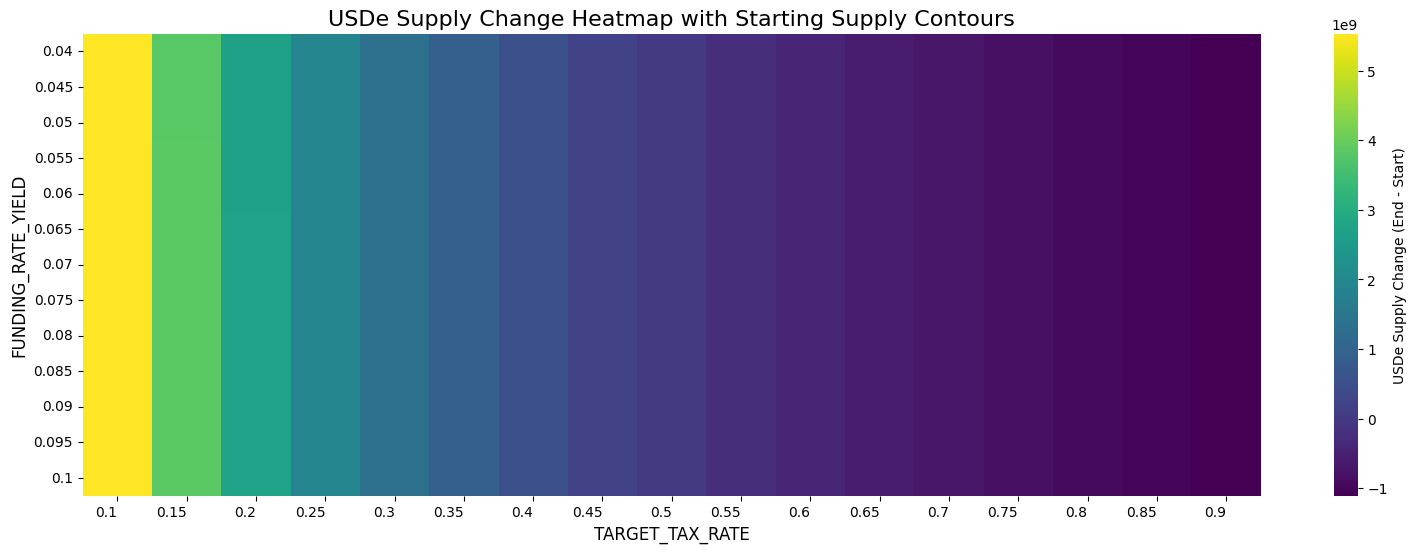

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot the data to create 2D matrices for both end and start supplies
heatmap_data_end = sensitivity_results_ext.pivot(index='FUNDING_RATE_YIELD', 
                                                 columns='TARGET_TAX_RATE', 
                                                 values='usde_supply_end')

heatmap_data_start = sensitivity_results_ext.pivot(index='FUNDING_RATE_YIELD', 
                                                   columns='TARGET_TAX_RATE', 
                                                   values='usde_supply_start')

# Calculate the difference between end and start supplies
heatmap_data_diff = heatmap_data_end - heatmap_data_start

# Create a larger figure
plt.figure(figsize=(19, 6))

# Create the heatmap for the difference
ax = sns.heatmap(heatmap_data_diff, 
                 cmap='viridis',  # Red-Yellow-Green colormap
                #  center=0,  # Center the colormap at 0
                 cbar_kws={'label': 'USDe Supply Change (End - Start)'})

# Add contour lines for the starting supply
contour = ax.contour(heatmap_data_start.values, 
                     colors='black', 
                     linewidths=1, 
                     extent=(0, len(heatmap_data_end.columns), 0, len(heatmap_data_end.index)))

# Add labels to the contour lines
plt.clabel(contour, inline=True, fontsize=8, fmt='%.2e')

# Set the title and labels
plt.title('USDe Supply Change Heatmap with Starting Supply Contours', fontsize=16)
plt.xlabel('TARGET_TAX_RATE', fontsize=12)
plt.ylabel('FUNDING_RATE_YIELD', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, ha='right')

# Show the plot
plt.show()

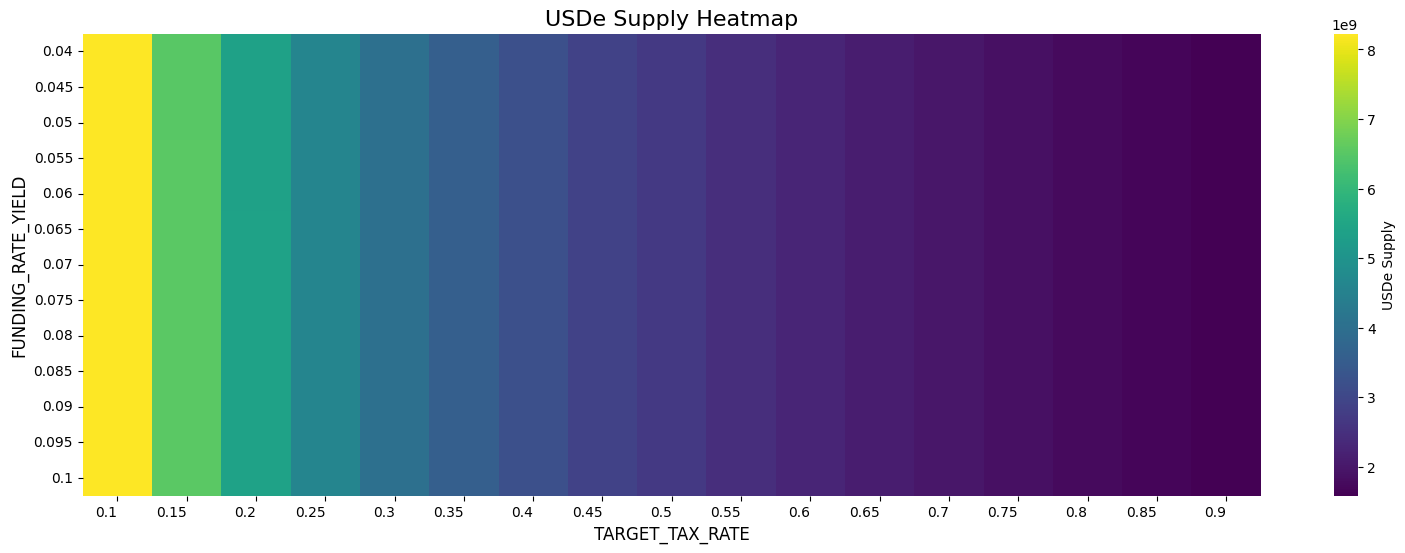

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data to create a 2D matrix suitable for a heatmap
heatmap_data = sensitivity_results_ext.pivot(index='FUNDING_RATE_YIELD', 
                                             columns='TARGET_TAX_RATE', 
                                             values='usde_supply_end')

# Create a larger figure
plt.figure(figsize=(19, 6))

# Create the heatmap
sns.heatmap(heatmap_data, 
            # annot=True, 
            # fmt='.2e',  # Scientific notation with 2 decimal places
            cmap='viridis',  # Yellow-Orange-Red color scheme, reversed
            cbar_kws={'label': 'USDe Supply'})

# Set the title and labels
plt.title('USDe Supply Heatmap', fontsize=16)
plt.xlabel('TARGET_TAX_RATE', fontsize=12)
plt.ylabel('FUNDING_RATE_YIELD', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, ha='right')

# # Adjust layout to prevent cutting off labels
# plt.tight_layout()

# Show the plot
plt.show()

- Creates a line plot showing the initial and final USDe supply for different target tax rates, given a specific funding rate yield (7%).


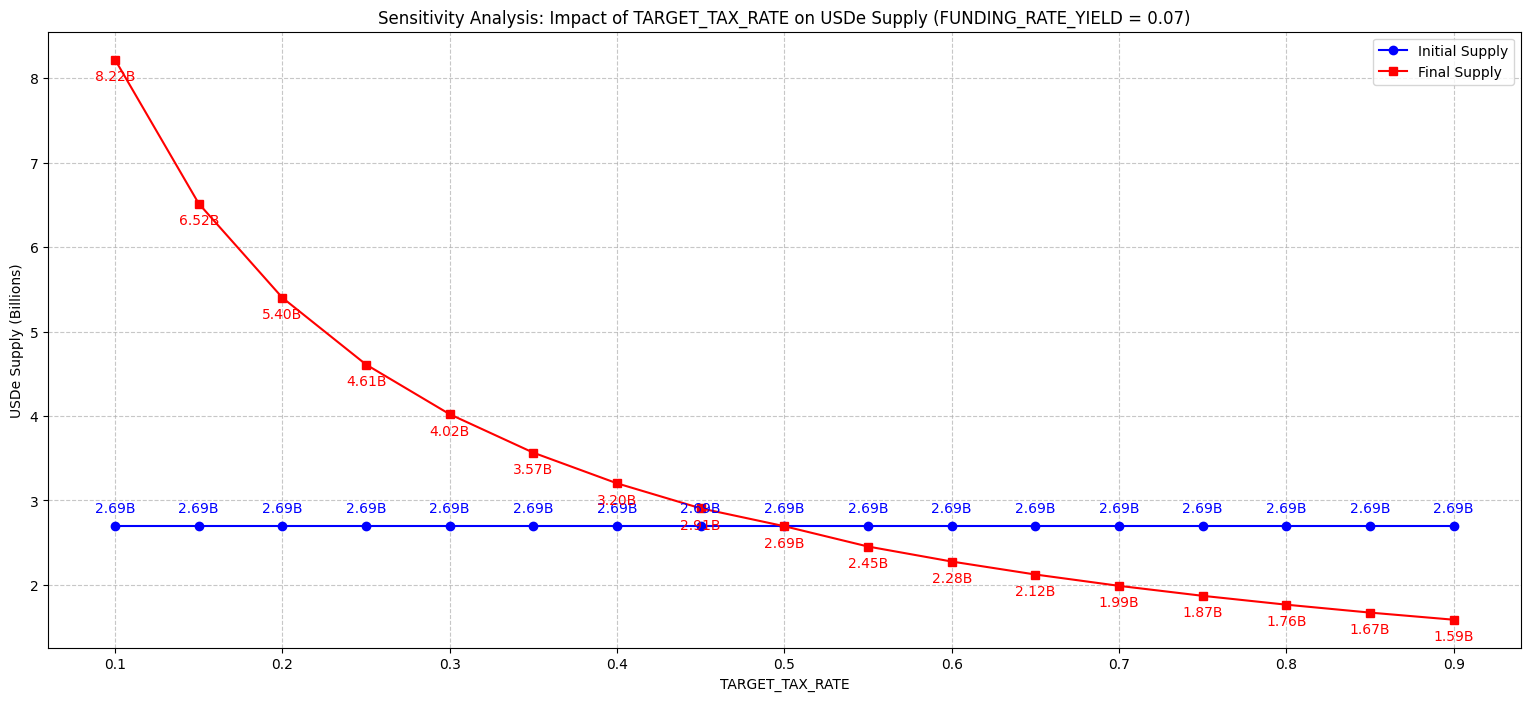

In [83]:
# Filter the sensitivity_results_ext dataframe for specific value in FUNDING_RATE_YIELD column  
filtered_data = sensitivity_results_ext[sensitivity_results_ext['FUNDING_RATE_YIELD'] == 0.07]

plt.figure(figsize=(19, 8))

tax_rates = filtered_data['TARGET_TAX_RATE']
initial_supplies = filtered_data['usde_supply_start'] / 1e9  # Convert to billions
final_supplies = filtered_data['usde_supply_end'] / 1e9  # Convert to billions

plt.plot(tax_rates, initial_supplies, marker='o', label='Initial Supply', color='blue')
plt.plot(tax_rates, final_supplies, marker='s', label='Final Supply', color='red')

plt.xlabel('TARGET_TAX_RATE')
plt.ylabel('USDe Supply (Billions)')
plt.title('Sensitivity Analysis: Impact of TARGET_TAX_RATE on USDe Supply (FUNDING_RATE_YIELD = 0.07)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add value labels
for i, (init, final) in enumerate(zip(initial_supplies, final_supplies)):
    plt.annotate(f'{init:.2f}B', (tax_rates.iloc[i], init), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f'{final:.2f}B', (tax_rates.iloc[i], final), 
                 textcoords="offset points", xytext=(0,-15), ha='center', color='red')

# plt.tight_layout()
plt.show()

# Print the data for verification
# for rate, init, final in zip(tax_rates, initial_supplies, final_supplies):
    # print(f"Tax Rate: {rate:.2f}, Initial Supply: {init:.2f} billion, Final Supply: {final:.2f} billion")